# Eniac

## Importing Data

Turning them into a dictionary of dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

orders_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orders_clean.parquet"
orderlines_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orderlines_clean.parquet"
products_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/products_clean.parquet"
brands_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/brands_clean.parquet"

# Loading dataframes directly from GitHub
orders_df = pd.read_parquet(orders_url)
orderlines_df = pd.read_parquet(orderlines_url)
products_df = pd.read_parquet(products_url)
brands_df = pd.read_parquet(brands_url)

orders = orders_df.copy()
orderlines = orderlines_df.copy()
products = products_df.copy()
brands = brands_df.copy()

Set Display Formats of Pandas

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 100)

Keys of tables:

order_id : orders, orderlines

sku = products, orderlines, brands --> the first three letters of sku = short brand name

Questions:

What is id: and unit_price: in orderlines?

What is total_paid in orders? What is created_date in orders?

## Data Integration

In [3]:
# Rename column to match with orders (better readability)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)

In [4]:
orderlines['short_brand'] = orderlines['sku'].str[:3]

In [5]:
# Merge Orderlines on brands, since both tables are small anyway
orderlines_brands = orderlines.merge(brands, left_on='short_brand' ,right_on='short', how='left')

In [6]:
oo = orders.merge(orderlines, on='order_id', how='left')
boo = oo.merge(brands, left_on ='short_brand', right_on='short', how='left')
df = boo.merge(products, on ='sku', how='left')

Delete oders where there is one or more products, which are not identified.

In [7]:
corrupted_orders = df.loc[df['sku'].isna()]
corrupted_order_ids = corrupted_orders['order_id'].unique()
df = df.loc[~df['order_id'].isin(corrupted_order_ids)]

In [8]:
df.isna().sum()

order_id               0
created_date           0
total_paid             0
state                  0
product_quantity       0
sku                    0
unit_price             0
date                   0
short_brand            0
short                296
long                 296
name                8924
desc                8924
price               8924
in_stock            8924
type                8924
dtype: int64

In [9]:
# Let's say you want to drop the columns 'column_name1', 'column_name2', and 'column_name3'
df.drop(columns=['short'], inplace=True)

- DataFrame **.describe()** gives basic numerical aggregations. It can be applied to a single column as well.
- DataFrame **.isna().any()** highlights which columns contain missing data
- DataFrame **.shape** gives the number of rows and columns
- DataFrame **.columns** gives the column names. Note that a list with new names can be passed to this attribute to rename the columns.
- DataFrame **.columnName.isna().sum()** is a quick way to check the number of missing values in a column
- DataFrame **.columnName.value_counts()** is a great way to summarise a categorical column. You can use it to discover how many orders are completed, cancelled, pending…
- DataFrame **.columnName.hist()** is an easy way to plot a histogram in a numerical column. Play with the bins argument to change the granularity of the graph.

## Create a new column with the Promo Price

In [10]:
df['promotion'] = df['unit_price'] < df['price']
df['estimated_promo_price'] = df.apply(lambda row: row['unit_price'] if row['promotion'] else np.nan, axis=1)
df[['estimated_promo_price','promotion', 'price']]

,estimated_promo_price,promotion,price
0,44.99,True,49.95
1,129.16,True,139.99
2,10.77,True,17.99
3,77.99,True,99.99
4,51.29,True,59.95
...,...,...,...
315951,42.99,True,49.95
315952,42.99,True,49.95
315953,141.58,True,215.98
315954,9.99,True,25.00


## Drop Orders which are not completed

In [11]:
df_com = df.loc[df['state']=='Completed'].reset_index(drop=True)
df_com.head()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short_brand,long,name,desc,price,in_stock,type,promotion,estimated_promo_price
0,241423,2017-11-06 13:10:02,136.15,Completed,1.00,LAC0212,129.16,2017-11-06 12:47:20,LAC,LaCie,LaCie Porsche Design Desktop Drive 4TB USB 3.0...,External Hard Drive 4TB 35-inch USB 3.0 for Ma...,139.99,True,11935397,True,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,1.00,PAR0074,10.77,2017-12-31 17:26:40,PAR,Parrot,Parrot 550mAh battery for MiniDrones,550mAh rechargeable battery for Parrot minidrones,17.99,False,11905404,True,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,1.00,OWC0074,77.99,2017-02-15 17:07:44,OWC,OWC,Mac OWC Memory 8GB 1066MHZ DDR3 SO-DIMM,8GB RAM Mac mini iMac MacBook and MacBook Pro ...,99.99,True,1364,True,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,1.00,TAD0007,149.00,2017-06-28 11:12:30,TAD,Tado,Tado Smart Climate Control Intelligent AC,intelligent control air conditioning works wit...,179.00,False,11905404,True,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,2.00,PAC1561,52.99,2017-01-21 12:49:00,PAC,Pack,"Macally External Hard Drive 1TB 35 ""USB 3.0 SA...",Aluminum External Hard Drive 1TB capacity form...,103.95,True,11935397,True,52.99


## Step 2: Analyzing Order Patterns in Relation to Discounts

Objective:
To understand if the introduction or availability of discounts affects order patterns – both in terms of quantity and frequency.

### 1. Understand basic metrics

In [103]:
total_orders = df_com['order_id'].nunique()
avg_order_value = df_com.groupby('order_id')['total_paid'].first().mean()

avg_items_per_order = df_com.groupby('order_id').size().mean()
print(f'The total orders are: {total_orders}, the average order values is: {avg_order_value}, and the average items per order are: {avg_items_per_order}')


The total orders are: 46560, the average order values is: 341.6464753006872, and the average items per order are: 1.333827319587629


Let me check if all total_paid values are the same within each order

In [42]:
unique_paid_counts = df_com.groupby('order_id')['total_paid'].nunique()
inconsistent_orders = unique_paid_counts[unique_paid_counts > 1]
if not inconsistent_orders.empty:
    print("There are orders with inconsistent 'total_paid' values:")
    print(inconsistent_orders)
else:
    print("All orders have consistent 'total_paid' values.")

All orders have consistent 'total_paid' values.


### Calculate the difference between the amount paid and total value of the order

In [140]:
df_com['unit_price_total'] = df_com['product_quantity']*df_com['unit_price']
order_total_price = df_com.groupby('order_id')['unit_price_total'].sum().reset_index()
order_total_price.rename(columns={'unit_price_total': 'order_unit_price_total'}, inplace=True)
df_merged = df_com.merge(order_total_price, on='order_id')
df_merged['diff_total_paid_unit_price'] = df_merged['total_paid'] - df_merged['order_unit_price_total']
avg_diff = df_merged['diff_total_paid_unit_price'].mean()
avg_diff

4.108193485016826

### 2. Segment Orders by Discounts:

Orders with discount include at least one item that was discounted, while orders without discounts include no discounted item.

In [135]:
df_com['order_inc_promo'] = df_com.groupby('order_id')['promotion'].transform('any')
df['order_inc_promo'] = df.groupby('order_id')['promotion'].transform('any')

In [128]:
df_com['order_inc_promo'].value_counts()

True     58389
False     3714
Name: order_inc_promo, dtype: int64

### 3. Compare Metrics

In [134]:
avg_order_value_discounted =(
    df_com[df_com['order_inc_promo'] == True]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_order_value_discounted =(
    df_com[df_com['order_inc_promo'] == False]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)

In [133]:
print(f'The average order value of discounted orders is: {avg_order_value_discounted}, compared to the average value of non discounted orders: {avg_order_value_non_discounted}\
. Moreover, the average number of items in an order with prmotion is: {avg_items_discounted}, while it is : {avg_items_non_discounted} for non discounted orders.')

The average order value of discounted orders is: 305.35, compared to the average value of non discounted orders: 401.01. Moreover, the average number of items in an order with prmotion is: 1.3, while it is : 1.08 for non discounted orders.


### 4. Temporal Analysis

For now only use completed orders, since otherwise we cannot infer about the promotion.

In [137]:
df.dtypes

order_id                         object
created_date             datetime64[ns]
total_paid                      float64
state                          category
product_quantity                float64
sku                              object
unit_price                      float64
date                     datetime64[ns]
short_brand                      object
long                             object
name                             object
desc                             object
price                           float64
in_stock                         object
type                           category
promotion                          bool
estimated_promo_price           float64
order_inc_promo                    bool
dtype: object

In [17]:
df_com['created_month'] = df_com['created_date'].dt.month
monthly_discounted_orders = df_com[df_com['promotion']].groupby('created_month').size()
monthly_discounted_orders

created_month
1     12278
2      6538
3      1948
4      1921
5      2141
6      1832
7      4310
8      2790
9      2600
10     3803
11     9521
12     6515
dtype: int64

### 5. Visual Analysis

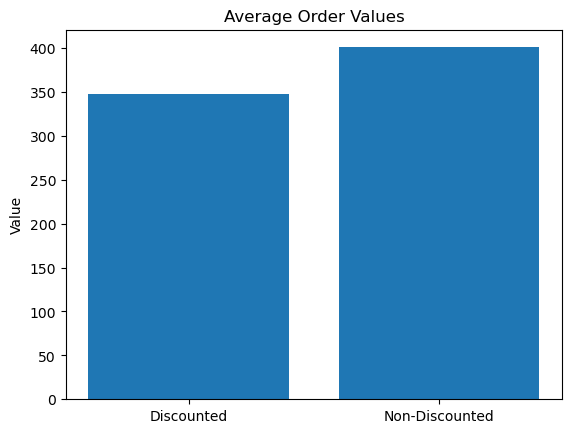

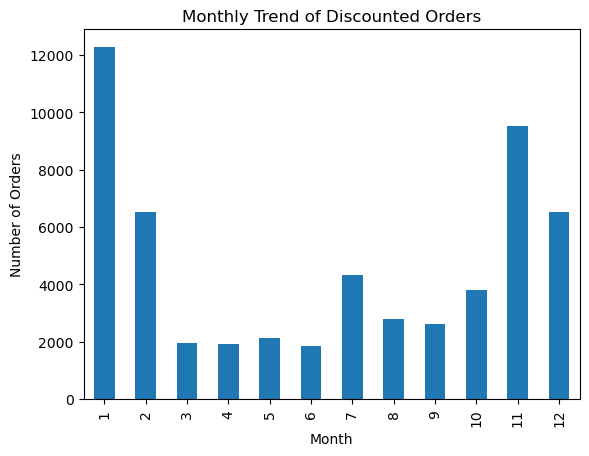

In [18]:
import matplotlib.pyplot as plt

# Average order values comparison
plt.bar(['Discounted', 'Non-Discounted'], [avg_order_value_discounted, avg_order_value_non_discounted])
plt.title('Average Order Values')
plt.ylabel('Value')
plt.show()

# Monthly trends of discounted orders
monthly_discounted_orders.plot(kind='bar')
plt.title('Monthly Trend of Discounted Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Month')
plt.show()


Possible Conclusions:

- If orders with discounts have a significantly higher average value or quantity, it suggests discounts might be driving larger orders.
- If there's a temporal trend showing increased discount orders during specific times, it might suggest seasonal trends or the effects of periodic discount campaigns.

## Step 3: Analyzing Customer Behavior and Retention with Respect to Discounts:

### 1. Retention Rate with Respect to Discounts:

To understand if customers acquired during promotional periods are more likely to come back.

In [19]:
df_com.groupby('order_id')['product_quantity'].sum()

order_id
241423   1.00
242832   1.00
243330   1.00
245275   1.00
245595   2.00
         ... 
527042   1.00
527070   2.00
527074   2.00
527096   3.00
527112   1.00
Name: product_quantity, Length: 46560, dtype: float64

In [20]:
duplicate_order_ids = df_com[df_com['order_id'].duplicated(keep=False)]

if not duplicate_order_ids.empty:
    print(f"There are {len(duplicate_order_ids)} duplicated order_ids in the dataset.")
else:
    print("All order_ids are unique.")


There are 25996 duplicated order_ids in the dataset.


In [21]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62103 entries, 0 to 62102
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               62103 non-null  object        
 1   created_date           62103 non-null  datetime64[ns]
 2   total_paid             62103 non-null  float64       
 3   state                  62103 non-null  category      
 4   product_quantity       62103 non-null  float64       
 5   sku                    62103 non-null  object        
 6   unit_price             62103 non-null  float64       
 7   date                   62103 non-null  datetime64[ns]
 8   short_brand            62103 non-null  object        
 9   long                   62065 non-null  object        
 10  name                   60362 non-null  object        
 11  desc                   60362 non-null  object        
 12  price                  60362 non-null  float64       
 13  i

Calculate the percentage of promotion for every product in every order: (1-(price/unit_price))

In [22]:
df_com['promo_perc'] = (1-(df_com['unit_price']/df_com['price']))

Average promotion perc per week/ month

In [23]:
df_com[['year', 'week', 'day']]= df_com['created_date'].dt.isocalendar()
# Extract month and quarter
df_com['month'] = df_com['created_date'].dt.month
df_com['quarter'] = df_com['created_date'].dt.quarter

In [24]:
grouped = (
    df_com
    .loc[df_com['state'] == 'Completed']
    .groupby(['week', 'month', 'quarter', 'year'])
    ['promo_perc']
    .mean()
    .reset_index()
)

grouped

,week,month,quarter,year,promo_perc
0,1,1,1,2017,0.22
1,1,1,1,2018,0.19
2,2,1,1,2017,0.26
3,2,1,1,2018,0.23
4,3,1,1,2017,0.23
5,3,1,1,2018,0.22
6,4,1,1,2017,0.27
7,4,1,1,2018,0.22
8,5,1,1,2017,0.24
9,5,1,1,2018,0.20


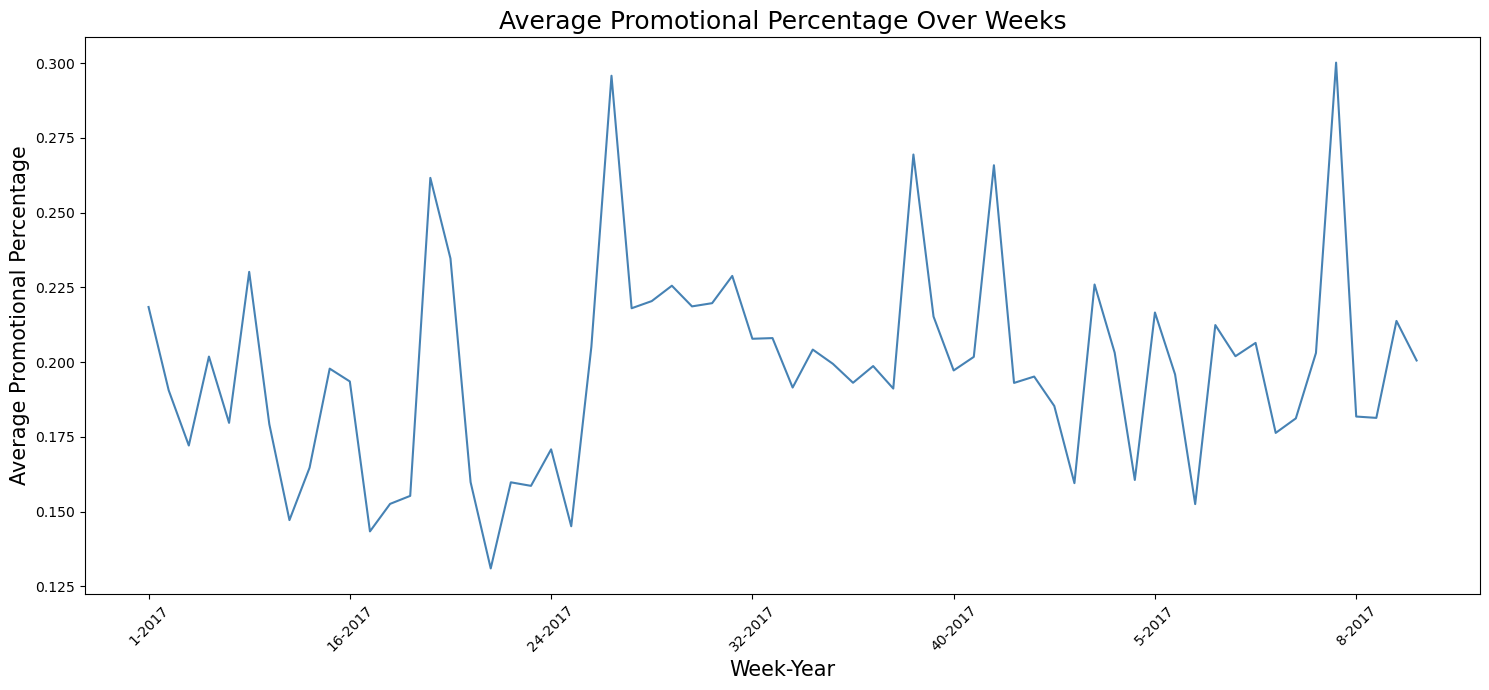

In [25]:
import matplotlib.pyplot as plt

# Creating 'week-year' for plotting
grouped['week-year'] = grouped['week'].astype(str) + '-' + grouped['year'].astype(str)

# Group by 'week-year' and calculate the mean of 'promo_perc'
weekly_promo = grouped.groupby('week-year')['promo_perc'].mean()

# Plot
plt.figure(figsize=(15, 7))
weekly_promo.plot(color='steelblue')
plt.title('Average Promotional Percentage Over Weeks', fontsize=18)
plt.xlabel('Week-Year', fontsize=15)
plt.ylabel('Average Promotional Percentage', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
 grouped =(
     df_com
     .loc[df_com['state']=='Completed']
     .groupby([df_com['created_date'].dt.isocalendar().week, df_com['created_date'].dt.month, df_com['created_date'].dt.quarter, df_com['created_date'].dt.isocalendar().year])
     ['promo_perc']
     .mean()
 )
#grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
print(grouped)

week  created_date  created_date  year
1     1             1             2017   0.22
                                  2018   0.19
2     1             1             2017   0.26
                                  2018   0.23
3     1             1             2017   0.23
                                  2018   0.22
4     1             1             2017   0.27
                                  2018   0.22
5     1             1             2017   0.24
                                  2018   0.20
      2             1             2017   0.20
                                  2018   0.19
6     2             1             2017   0.18
                                  2018   0.18
7     2             1             2017   0.20
                                  2018   0.30
8     2             1             2017   0.18
                                  2018   0.18
9     2             1             2017   0.18
                                  2018   0.19
      3             1             2017   

Make the Line Plot

look for weeks/months/days where promotion in percentage/ price high. Which one to use?